In [ ]:
%pip install langchain langchain_core --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 8.3 MB/s eta 0:00:00


## Retrieval Augmented Generation (RAG)

A prompting technique, proposed by [lewis et al](https://arxiv.org/abs/2005.11401) that combines methods from Information Retrieval (IR) and Natural Language Generation (NLG) to ground an LLM's response given relevant context to a query. Common applications lie in Closed and Open-Domain Question Answering tasks. It has become one of the go to techniques in industry and research because it is low-cost and quite straightforward to implement at scale. It mainly relies on an "emergent property" of LLMs called in-context learning.  

**Setup:**

1. [Document Loaders](https://python.langchain.com/v0.1/docs/modules/data_connection/document_loaders/)

2.  [Split Documents](https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/)

3. [Embed Splits](https://python.langchain.com/v0.1/docs/modules/data_connection/text_embedding/)

4. [Index Embeddings](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/)

5. [Retrieve](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/)

6. [Build RAG Chain](https://python.langchain.com/v0.1/docs/modules/chains/)


## Evaluation & LogProbs (extra)

[logprobs](https://python.langchain.com/v0.2/docs/how_to/logprobs/)

## Loading Documents

There are many formats supported: CSV, PDF, TXT, MD, Directories (i.e., folders), HTML, and JSON. You can also write a custom class to support specific types of documents. The only difference with regular python functions to read files is that these document loaders return LangChain `Document` objects readily available for further text processing.

In [ ]:
%pip install langchain_community pypdf --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
# Load documents
from langchain_community.document_loaders import PyPDFLoader

file_path = "/content/SmallScaleSocieties_HenrichEtAl.pdf" # replace with any PDF file path

loader = PyPDFLoader(file_path)
docs = loader.load()

# test
print(len(docs))
print(type(docs))
print(type(docs[0])) # langchain object
print(len(docs[0].page_content.split(" "))) # approx tokens

6
<class 'list'>
<class 'langchain_core.documents.base.Document'>
491


In [ ]:
docs[:2]

[Document(page_content='In Search of Homo Economicus: Behavioral Experiments\nin 15 Small-Scale Societies\nByJOSEPHHENRICH,ROBERTBOYD,SAMUELBOWLES,COLINCAMERER,ERNSTFEHR,\nHERBERTGINTIS,ANDRICHARDMCELREATH*\nRecent investigations have uncovered large,\nconsistentdeviationsfromthepredictionsofthetextbook representation of Homo economicus\n(Alvin E. Roth et al., 1991; Ernst Fehr andSimon Ga ¨chter, 2000; Colin Camerer, 2001).\nOne problem appears to lie in economists’ ca-nonical assumption that individuals are entirelyself-interested: in addition to their own materialpayoffs, many experimental subjects appear tocare about fairness and reciprocity, are willingto change the distribution of material outcomesat personal cost, and are willing to reward thosewho act in a cooperative manner while punish-ing those who do not even when these actionsare costly to the individual. These deviationsfrom what we will term the canonical modelhave important consequences for a wide rangeof economic phenom

## Splitting Documents


In [ ]:
%pip install langchain-text-splitters --quiet

In [ ]:
# Split
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Split by Paragraph → (if chunk size still big) → Spit by new line → (if chunk size still big) → Split by words...
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, # characters
    chunk_overlap=25, # some overlap to carry over context
    length_function=len,
    is_separator_regex=False,
    separators=['\n\n','\n', " "] # split paragraphs, then sentences, then words
)

splits = text_splitter.split_documents(docs)

# test
print(len(splits)) # number of chunks created
print(type(splits[0])) # langchain object
print(len(splits[1].page_content))
print(len(splits[0].page_content.split(" "))) # approx tokens

67
<class 'langchain_core.documents.base.Document'>
493
32


We can visualize how the various text splitters work using [chunkViz](https://chunkviz.up.railway.app/)

## Creating and Indexing Text Embeddings

In [ ]:
%pip install sentence_transformers langchain_chroma --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 559.5/559.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB

In [ ]:
# now, we can create vector representations (embeddings) of our chunks
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_chroma import Chroma

embeddings_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma.from_documents(splits, embeddings_model)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/sett

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# test
vectorstore.similarity_search("Who are the authors of the paper?")

[Document(page_content='overview paper is avail-able online.', metadata={'page': 0, 'source': '/content/SmallScaleSocieties_HenrichEtAl.pdf'}),
 Document(page_content='numbers given in parentheses.eIncludes experimenter-generated low offers.74 AEA PAPERS AND PROCEEDINGS MAY 2001', metadata={'page': 1, 'source': '/content/SmallScaleSocieties_HenrichEtAl.pdf'}),
 Document(page_content='ferring to the widespread institution of village-level voluntary contributions for public-goodsprojects such as schools or roads. Not surpris-ingly, they contributed generously (58 percentof the stake), somewhat higher than most U.S.subjects contribute in similar experiments.\nIII. Discussion\nOur data indicate that the degree of cooper-\nation, sharing, and punishment exhibited by76 AEA PAPERS AND PROCEEDINGS MAY 2001', metadata={'page': 3, 'source': '/content/SmallScaleSocieties_HenrichEtAl.pdf'}),
 Document(page_content='In Search of Homo Economicus: Behavioral Experiments\nin 15 Small-Scale Societies\n

### Visualizing embeddings and Model Comparison

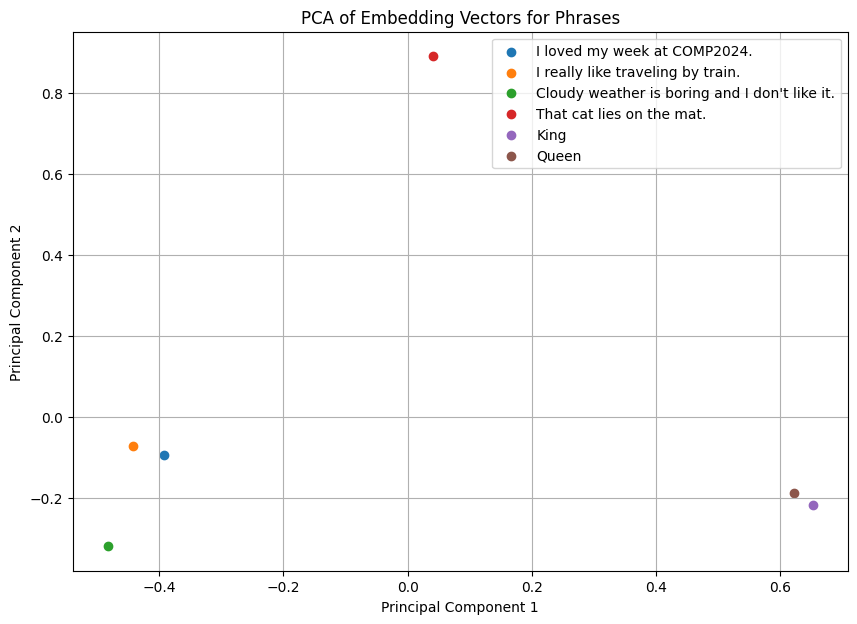

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

phrases = [
    "I loved my week at COMP2024.",
    "I really like traveling by train.",
    "Cloudy weather is boring and I don't like it.",
    "That cat lies on the mat.",
    "King",
    "Queen"
]

#
embeddings_vectors = [embeddings_model.embed_query(phrase) for phrase in phrases]

# Use PCA to reduce the dimensionality for visualization purposes
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(embeddings_vectors)

# Plot the vectors
plt.figure(figsize=(10, 7))
for i, phrase in enumerate(phrases):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], label=phrase)

plt.title("PCA of Embedding Vectors for Phrases")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

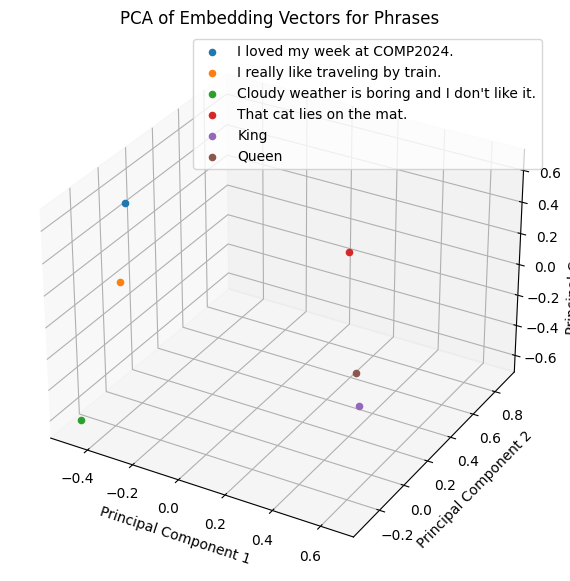

In [ ]:
# end 3D
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(embeddings_vectors)

# Plot the vectors in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, phrase in enumerate(phrases):
    ax.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], reduced_vectors[i, 2], label=phrase)

ax.set_title("PCA of Embedding Vectors for Phrases")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.legend()
plt.show()

In [ ]:
%pip install langchain-openai --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 637.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00


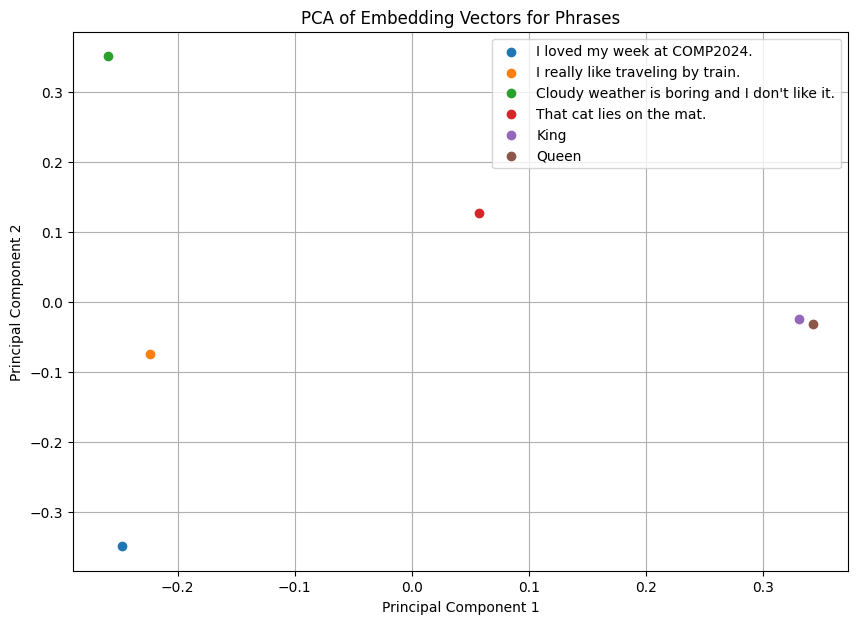

In [ ]:
from langchain_openai import OpenAIEmbeddings
import os

os.environ['OPENAI_API_KEY'] = "" # your OpenAI API key

# Initialize the embeddings model
embeddings = OpenAIEmbeddings()

# Embed the phrases
embeddings_vectors = [embeddings.embed_query(phrase) for phrase in phrases]

# Use PCA to reduce the dimensionality for visualization purposes
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(embeddings_vectors)

# Plot the vectors
plt.figure(figsize=(10, 7))
for i, phrase in enumerate(phrases):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], label=phrase)

plt.title("PCA of Embedding Vectors for Phrases")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

## Retrieval

In [ ]:
# VectorStore Retrieval
vdb_retriever = vectorstore.as_retriever(search_type="similarity", # mmr
                                         search_kwargs={"k": 5}) # retrieve k chunks

# test
vdb_retriever.invoke("Who are the authors of this paper?")

[Document(page_content='numbers given in parentheses.eIncludes experimenter-generated low offers.74 AEA PAPERS AND PROCEEDINGS MAY 2001', metadata={'page': 1, 'source': '/content/SmallScaleSocieties_HenrichEtAl.pdf'}),
 Document(page_content='ferring to the widespread institution of village-level voluntary contributions for public-goodsprojects such as schools or roads. Not surpris-ingly, they contributed generously (58 percentof the stake), somewhat higher than most U.S.subjects contribute in similar experiments.\nIII. Discussion\nOur data indicate that the degree of cooper-\nation, sharing, and punishment exhibited by76 AEA PAPERS AND PROCEEDINGS MAY 2001', metadata={'page': 3, 'source': '/content/SmallScaleSocieties_HenrichEtAl.pdf'}),
 Document(page_content='In Search of Homo Economicus: Behavioral Experiments\nin 15 Small-Scale Societies\nByJOSEPHHENRICH,ROBERTBOYD,SAMUELBOWLES,COLINCAMERER,ERNSTFEHR,\nHERBERTGINTIS,ANDRICHARDMCELREATH*\nRecent investigations have uncovered large,

In [ ]:
%pip install --upgrade --quiet rank_bm25

In [ ]:
# Ensemble Retrieval
from langchain.retrievers import EnsembleRetriever
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(splits,
                                              k=5)

ensemble = EnsembleRetriever(retrievers=[bm25_retriever, vdb_retriever],
                             weights=[0.3, 0.7])
# test
ensemble.invoke("Who are the authors of this paper?")

[Document(page_content='numbers given in parentheses.eIncludes experimenter-generated low offers.74 AEA PAPERS AND PROCEEDINGS MAY 2001', metadata={'page': 1, 'source': '/content/SmallScaleSocieties_HenrichEtAl.pdf'}),
 Document(page_content='ferring to the widespread institution of village-level voluntary contributions for public-goodsprojects such as schools or roads. Not surpris-ingly, they contributed generously (58 percentof the stake), somewhat higher than most U.S.subjects contribute in similar experiments.\nIII. Discussion\nOur data indicate that the degree of cooper-\nation, sharing, and punishment exhibited by76 AEA PAPERS AND PROCEEDINGS MAY 2001', metadata={'page': 3, 'source': '/content/SmallScaleSocieties_HenrichEtAl.pdf'}),
 Document(page_content='In Search of Homo Economicus: Behavioral Experiments\nin 15 Small-Scale Societies\nByJOSEPHHENRICH,ROBERTBOYD,SAMUELBOWLES,COLINCAMERER,ERNSTFEHR,\nHERBERTGINTIS,ANDRICHARDMCELREATH*\nRecent investigations have uncovered large,

## LLM Generation

We can use open-source models from [Groq](https://console.groq.com/docs/models)'s cloud to benefit from faster inference. But there are many ways to run these models using python. LangChain makes it very easy to develop flexible LLM based applications because they support a vast array of integrations.

In [ ]:
%pip install langchain_groq --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 1.4 MB/s eta 0:00:00


In [ ]:
# Get LLM and generate response
from langchain_groq import ChatGroq
import os

os.environ['GROQ_API_KEY'] = "" # your GROQ API key

llama3 = ChatGroq(model='llama3-8b-8192', # mixtral-8x7b-32768
                  temperature=0,
                  max_tokens=500)

# test no context
llama3.invoke("Who are the authors of the 'In Search of Homo Economicus: Behavioral Experiments in 15 Small-Scale Societies' paper?").content


'The authors of the paper "In Search of Homo Economicus: Behavioral Experiments in 15 Small-Scale Societies" are:\n\n1. Joseph Henrich\n2. Steven J. Heine\n3. Ara Norenzayan\n\nThis paper was published in the journal "Science" in 2010.'

In [ ]:
# test with context
relevant_docs = ensemble.invoke("Who are the authors of this paper?")
context = "".join([doc.page_content for doc in relevant_docs])

prompt = f"""Who are the authors of the
        'In Search of Homo Economicus: Behavioral Experiments in 15 Small-Scale Societies' paper?

        {context}
        """

llama3.invoke(prompt).content

'The authors of the paper "In Search of Homo Economicus: Behavioral Experiments in 15 Small-Scale Societies" are:\n\n1. Joseph Henrich\n2. Robert Boyd\n3. Samuel Bowles\n4. Colin Camerer\n5. Ernst Fehr\n6. Herbert Gintis\n7. Richard McElreath'

Now we need a way of putting everything together. Specially because the retrieval must be made at runtime given the user query. This means that the prompt must be dynamics (i.e., constructed conditional on the information retrieved).

### Chains

Chains in LangChain are squential programs that combine objects that either run in Parallel (all take the same input and do something) or Sequential (the output of each object becomes an input to the following one). It makes it very easy to orchestrate LLM-based applications, and LangChain offers production grade functionalities to run the chains asynchronously as well as logging or evaluating.

In [ ]:
# RAG chain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

# utility
def format_docs(retrieved_docs):
    return "\n\n".join(doc.page_content for doc in retrieved_docs)

# Prompt
prompt_template = """
        Answer the user question, shown below, using the information provided as context.
        If you don't know the answer state 'I don't know', avoid making up answers.

        <context>
        {context}
        </context>

        Question: {question}

        Answer: """

prompt = PromptTemplate.from_template(prompt_template)

rag_chain = RunnableParallel(context = ensemble | format_docs, question = RunnablePassthrough() ) | prompt | llama3

rag_chain.invoke("Who are the authors of this paper?")

AIMessage(content='The authors of this paper are:\n\n* Joseph Henrich\n* Robert Boyd\n* Samuel Bowles\n* Colin Camerer\n* Ernst Fehr\n* Herbert Gintis\n* Richard McElreath', response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 841, 'total_tokens': 885, 'completion_time': 0.034123959, 'prompt_time': 0.127957421, 'queue_time': None, 'total_time': 0.16208138}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_af05557ca2', 'finish_reason': 'stop', 'logprobs': None}, id='run-9f18a21f-75c4-4291-a242-52841575a2f4-0')

In [ ]:
rag_chain.invoke("Who are the authors of this paper?").content

'The authors of this paper are:\n\n* Joseph Henrich\n* Robert Boyd\n* Samuel Bowles\n* Colin Camerer\n* Ernst Fehr\n* Herbert Gintis\n* Richard McElreath'

In [ ]:
# LogProbs
from langchain_openai import ChatOpenAI

gpt4o = ChatOpenAI(model='gpt-4o',
                   temperature=0,
                   max_tokens=500).bind(logprobs=True)

rag_chain_gpt4o = RunnableParallel(context = ensemble | format_docs, question = RunnablePassthrough() ) | prompt | gpt4o

rag_chain_gpt4o.invoke("Who are the authors of this paper?").content

'The authors of the paper are Joseph Henrich, Robert Boyd, Samuel Bowles, Colin Camerer, Ernst Fehr, Herbert Gintis, and Richard McElreath.'

In [ ]:
rag_chain_gpt4o.invoke("Who are the authors of this paper?").response_metadata["logprobs"]["content"]

[{'token': 'The',
  'bytes': [84, 104, 101],
  'logprob': -0.11103121,
  'top_logprobs': []},
 {'token': ' authors',
  'bytes': [32, 97, 117, 116, 104, 111, 114, 115],
  'logprob': -2.1008714e-06,
  'top_logprobs': []},
 {'token': ' of', 'bytes': [32, 111, 102], 'logprob': 0.0, 'top_logprobs': []},
 {'token': ' the',
  'bytes': [32, 116, 104, 101],
  'logprob': -0.34844705,
  'top_logprobs': []},
 {'token': ' paper',
  'bytes': [32, 112, 97, 112, 101, 114],
  'logprob': 0.0,
  'top_logprobs': []},
 {'token': ' are',
  'bytes': [32, 97, 114, 101],
  'logprob': -0.0010005363,
  'top_logprobs': []},
 {'token': ' Joseph',
  'bytes': [32, 74, 111, 115, 101, 112, 104],
  'logprob': -0.0011069943,
  'top_logprobs': []},
 {'token': ' Hen',
  'bytes': [32, 72, 101, 110],
  'logprob': -2.220075e-06,
  'top_logprobs': []},
 {'token': 'rich',
  'bytes': [114, 105, 99, 104],
  'logprob': -5.5122365e-07,
  'top_logprobs': []},
 {'token': ',', 'bytes': [44], 'logprob': -1.9361265e-07, 'top_logprobs':

- **Higher Negative Log Probabilities**: A more negative log probability indicates a lower probability of the token being the next one in the sequence.

- **Closer to Zero Log Probabilities**: Values closer to zero indicate a higher probability of the token being the next one.

## Exercises

1. Rerun the RAG chain with your own document

2. Compare logprobs of GPT's answer with and without RAG.

3. Write a function to parametrize the temperature of the LLM. Run it for temperatures {0, 0.3, 0.75, 1, 1.3, 1.7} keeping the prompt constant. What qualitative differences do you notice?

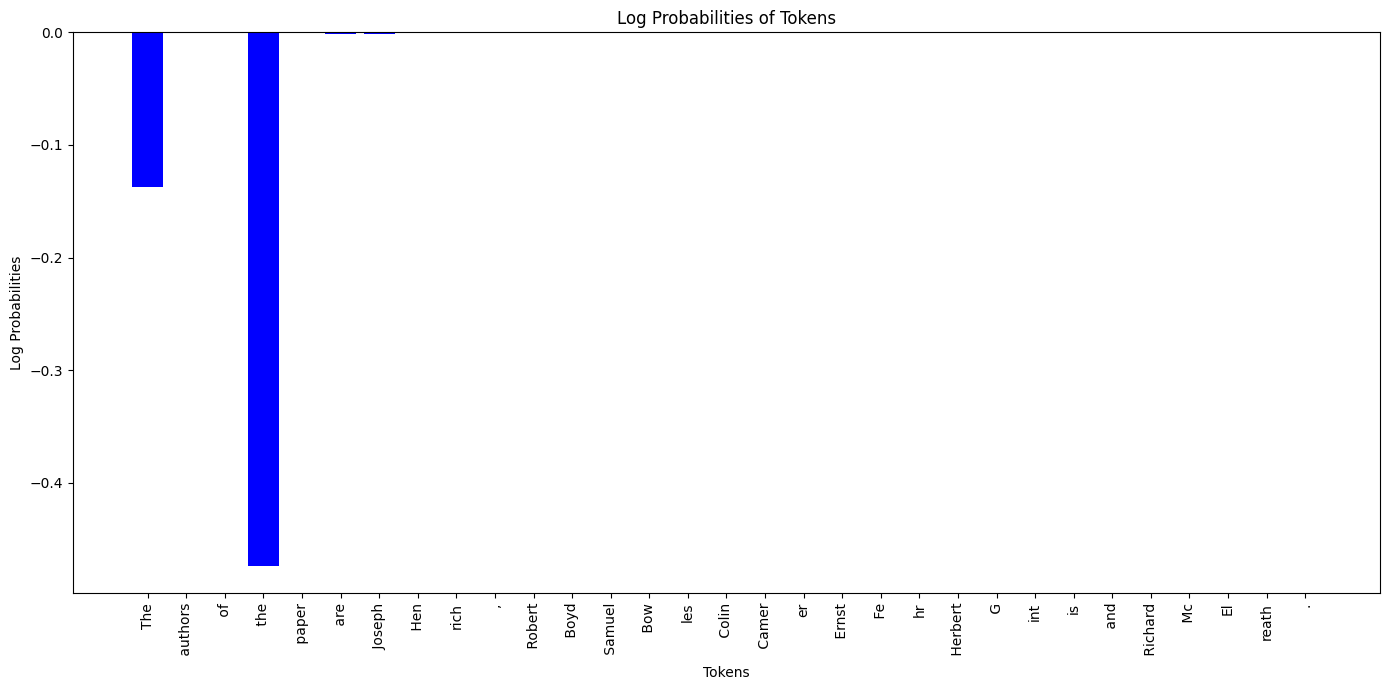

In [ ]:
import matplotlib.pyplot as plt

def extract_tokens_and_logprobs(data):
    tokens = [entry['token'] for entry in data]
    logprobs = [entry['logprob'] for entry in data]
    return tokens, logprobs

def plot_logprobs(tokens, logprobs):
    plt.figure(figsize=(14, 7))
    plt.bar(tokens, logprobs, color='blue')
    plt.xlabel('Tokens')
    plt.ylabel('Log Probabilities')
    plt.title('Log Probabilities of Tokens')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

response = rag_chain_gpt4o.invoke("Who are the authors of this paper?").response_metadata["logprobs"]["content"]

tokens, logprobs = extract_tokens_and_logprobs(response)
plot_logprobs(tokens, logprobs)

## Literature & Resources

- [RAG paper](https://arxiv.org/abs/2005.11401)

- [SelfAsk Prompt](https://arxiv.org/abs/2210.03350)

- [Chain of Thought Prompt](https://arxiv.org/abs/2201.11903)

- [RAG + UI Python tutorial](https://agbonorino21.wixsite.com/econllm-lab/projects-6)

- [Epistemic vs Aleatoric Uncertainty - DeepMind](https://paperswithcode.com/paper/to-believe-or-not-to-believe-your-llm)

- [Lost in the middle - Anthropic](https://arxiv.org/abs/2307.03172)

- [Semantic Uncertainty - Oxford](https://arxiv.org/abs/2302.09664)

- [RAG vs Fine-tuning in Industry - Microsoft](https://arxiv.org/pdf/2401.08406)

- [RAG vs Fine-tuning for Less Popular Knowledge](https://arxiv.org/html/2403.01432v1)

- [In-context Learning](https://arxiv.org/pdf/2301.00234)

- [Homo silicus](https://arxiv.org/abs/2301.07543)

- [LLMs in Survey Methodology](https://www.scitepress.org/Link.aspx?doi=10.5220/0011985400003470)

- [Inspecting Emergent Behavior Through Iterated Prisoner's Dilemma](https://arxiv.org/pdf/2305.07970)